# Assigment Paper:

![image](https://user-images.githubusercontent.com/55464049/114030959-8c7be680-9883-11eb-932b-44146b041417.png)




[Adam](https://arxiv.org/pdf/1412.6980v1.pdf)

[AdamW](https://arxiv.org/abs/1711.05101v3)


[Focal Loss](https://arxiv.org/abs/1708.02002v2)

[Dice](https://arxiv.org/pdf/1707.03237.pdf)

 __UPDATE 14April2021__

 ![image](https://user-images.githubusercontent.com/55464049/114354049-65206480-9b76-11eb-8a88-d5d1416ab0dd.png)


# Lec Preperation

##1. Optimizers Read & Summarize 

### 1.1 Adam
a method for efficient stochastic optimization that only requires first-order gradients and requires little memory.

Consists of 2 main methods for reaching fast to the minimum.

1. Momentum: keeping the general direction of the movement. helps avoiding local minimums, and acts like a ball goin down a hill.
![image](https://user-images.githubusercontent.com/55464049/114276061-b244ef00-9a2d-11eb-9c33-feaa59b257a7.png)


2. RMSProp: (a better version of AdaGrad which keeping track of a historical average of square of gradient values)
![image](https://user-images.githubusercontent.com/55464049/114275988-5e3a0a80-9a2d-11eb-854c-d0af3e60f02a.png)
, in RMSProp we also add friction (decay) 
![image](https://user-images.githubusercontent.com/55464049/114275942-14e9bb00-9a2d-11eb-97b8-c200f235ba48.png)
which will not allow the values to explode.
The RMSProp arrests progress along the fast moving direction while simultaneously accelerating progress along slow moving directions, which helps it to bend directly towards the bottom.

![image](https://user-images.githubusercontent.com/55464049/114276907-6d22bc00-9a31-11eb-854a-d903d36e5793.png)



### 1.2 AdamW Optimizer
A simple modification from Adam to recover the original formulation of weight decay regularization by __decoupling__ the weight decay from the optimization steps taken. The weight decay is calculated _after_ the main calculation, and therefore does not interrupt with the them.

[Link](https://towardsdatascience.com/why-adamw-matters-736223f31b5d)
![image](https://user-images.githubusercontent.com/55464049/114277470-fe932d80-9a33-11eb-9158-9967d370654e.png)


### 1.3 SGD
Basically, when we want to progress with our model:
* we can check one example, check the error, compute the gradients and change the network. but, one example can be biased in many ways, and contains an unknown amount of noise. __1 example__.

* So in order to find patterns, and go in the right direction, most likely is that we'll want to check all of our examples, average the direction, compute the loss and backdrop according to all of it.
but, if we have a lot of data (millions-billions..) computing and averaging all the examples for each step will take VERY much time. __N examples__.

* so, we try to find a middle way, here is where __SGD__ comes in! 
We'll randomly subsample our dataset to groups who each have k samples in it.
So rather than computing the loss on the full data-set, in each step we'll compute the loss over a minibatch, and backprop accordingly. __n examples__.

![image](https://user-images.githubusercontent.com/55464049/114276150-2384a200-9a2e-11eb-9c8d-fc12851f536c.png)


## 2. Optimizer Implemetations

### 2.1 AdamW Implementation

In [ ]:
# from: https://github.com/egg-west/AdamW-pytorch/blob/master/adamW.py
import math
import torch
from torch.optim.optimizer import Optimizer

class AdamW(Optimizer):
    """Implements Adam algorithm.
    It has been proposed in `Adam: A Method for Stochastic Optimization`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad)
        super(AdamW, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AdamW, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']


                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                # if group['weight_decay'] != 0:
                #     grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # p.data.addcdiv_(-step_size, exp_avg, denom)
                p.data.add_(-step_size,  torch.mul(p.data, group['weight_decay']).addcdiv_(1, exp_avg, denom) )

        return loss


### 2.2 Adam

In [ ]:
import torch
import math
from torch.optim import Adam, SGD

import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader


### 2.3 Choose Optimizer:

In [ ]:
LR = 0.01
BATCH_SIZE = 32
EPOCH = 12
WD = 0.1

def set_optimizer(opt_name, params, learningRate):
    if opt_name == 'SGD':
        optimizer = optim.SGD(params, lr=learningRate)
    elif opt_name == 'Adam':
        optimizer = optim.Adam(params, lr=learningRate)
    elif opt_name == 'AdamW':
        optimizer = AdamW(params, lr=learningRate, betas=(0.9, 0.99), weight_decay = 0.1)
    else:
        print(f'no {opt_name} optimizer availble, choosing Adam by default.')
        optimizer = optim.Adam(params, lr=learningRate)
    
    if optimizer:
        return optimize

## 3. Losses Read & Summarize 

### 3.1 Cross Entropy - CE
The Cross Entropy function is a way to measure the loss of classification problem. It must be activated after softmax function, which calculates the odds for specific class to be choosen. If the network is 100% sure of a class, it will give it score of 1, and in this case we will have no loss, which means that the NN will not be modified.
The Step size is accoding to the loss, if the loss is high, the CE derivetive will be steep, therefor the step size will be bigger.

[Stat-Quest Video](https://www.youtube.com/watch?v=6ArSys5qHAU&ab_channel=StatQuestwithJoshStarmer)

![image](https://user-images.githubusercontent.com/55464049/114303193-9563f680-9ad5-11eb-9a0b-f6cd93b6ddad.png)


### 3.2 Binary Cross Entropy with logits loss

[What is Logits](https://stackoverflow.com/questions/34240703/what-is-logits-what-is-the-difference-between-softmax-and-softmax-cross-entropy)


* Logits:  the function operates on the unscaled output, that __the values are not probabilities__.

* Binary Cross Entropy: Cross Entropy of only 2 categories.


[Pytorch Link:](https://pytorch.org/docs/master/generated/torch.nn.BCEWithLogitsLoss.html#torch.nn.BCEWithLogitsLoss)
This loss combines a Sigmoid layer and the BCELoss in one single class. This version is more numerically stable than using a plain Sigmoid followed by a BCELoss as, by combining the operations into one layer, we take advantage of the log-sum-exp trick for numerical stability.



### 3.3 Focal Loss
Focal Loss is a modulated CE function which reduces the loss for easy / common examples, whereas keep the loss for the hard / rare examples.
When __Gamma==0 <=> FocalLoss == CE__ , when gamma 

this approach is useful in many Image Classification Problems.
![image](https://user-images.githubusercontent.com/55464049/114303741-4f5c6200-9ad8-11eb-8edd-5ec9e6cfd095.png)

Another way, apart from Focal Loss, to deal with class imbalance is to introduce weights. Give high weights to the rare class and small weights to the dominating or common class. These weights are referred to as α.

![image](https://user-images.githubusercontent.com/55464049/114303812-aa8e5480-9ad8-11eb-9bf2-b56d8f29620b.png)



### 3.4 Dice

Dice loss is based on the Sorensen-Dice coefficient or Tversky index, which attaches similar importance to false positives and false negatives, and is more immune to the data-imbalance issue. To further alleviate the dominating influence from easy-negative examples in training, we propose to associate training examples with dynamically adjusted weights to deemphasize easy-negative examples.

Dice's formula:
![image](https://user-images.githubusercontent.com/55464049/114304068-e83fad00-9ad9-11eb-9bb9-3ab066dddd02.png)

[Dice impelemtation:](https://www.jeremyjordan.me/semantic-segmentation/#:~:text=around%20the%20cells.%20(-,Source),denotes%20perfect%20and%20complete%20overlap.)

In [ ]:
# from : https://www.jeremyjordan.me/semantic-segmentation/#:~:text=around%20the%20cells.%20(-,Source),denotes%20perfect%20and%20complete%20overlap.
def soft_dice_loss(y_true, y_pred, epsilon=1e-6): 
    # skip the batch and class axis for calculating Dice score
    axes = tuple(range(1, len(y_pred.shape)-1)) 
    numerator = 2. * np.sum(y_pred * y_true, axes)
    denominator = np.sum(np.square(y_pred) + np.square(y_true), axes)
    
    return 1 - np.mean((numerator + epsilon) / (denominator + epsilon)) # average over classes and batch
    # thanks @mfernezir for catching a bug in an earlier version of this implementation!

## 4. Losses Implementations:



### 4.1  Focal Loss


In [ ]:
def focal_loss(pt, alpha, gama):
    return (-1) * alpha * ((1 - pt)**gama) * np.log(pt)

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.2, gama=2, logist=False, reduce='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.cross_entropy_loss = nn.CrossEntropyLoss()
        self.reduce = reduce

    def forward(self, inputs, targets):
        BCE_loss = self.cross_entropy_loss(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_losss = self.alpha * (1-pt) **self.gama * BCE_loss
        if self.reduce:
            return torch.mean(F_loss)
        return F_loss

### Snippets

In [ ]:
import torch
import math
from torch.optim import Adam, SGD
from torch.optim.optimizer import Optimizer, required

N, D_in, H, D_out = 64, 1000, 100, 10

x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)
loss_fn = torch.nn.MSELoss(reduction='sum')


learning_rate = 1e-4

display(model.parameters())
for parm in model.parameters():
    print(f' {parm.shape} \t')
optimizer = AdamW(model.parameters(), lr=learning_rate)
for t in range(500):

    y_pred = model(x)

    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

<generator object Module.parameters at 0x7f7a0f461d50>

 torch.Size([100, 1000]) 	
 torch.Size([100]) 	
 torch.Size([10, 100]) 	
 torch.Size([10]) 	


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)


99 46.7319221496582
199 0.8154428601264954
299 0.026522746309638023
399 0.0012860035058110952
499 3.049271799682174e-05


# IN Class Practice:

In [ ]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import tensorflow.keras.datasets.mnist as mnist
from torch.utils.data import Dataset , DataLoader
from sklearn.metrics import confusion_matrix
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from torch.autograd import Variable

%matplotlib inline

In [ ]:
!pip install torchmetrics


     |████████████████████████████████| 276kB 17.8MB/s 


### How to step the optimizer

In [ ]:
import torchmetrics


In [ ]:
model = nn.Linear(1,1)


In [ ]:
sgd = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9, nesterov=True)
# momentum : Parameter that accelerate SGD in relevant direction and dampens oscillations
sgd.step()

In [ ]:
adam = optim.Adam(model.parameters(), lr = 0.001, betas = (0.9, 0.999), eps = 1e-08, weight_decay=0, amsgrad=False)
adam.step()

In [ ]:
# adamw = optim.AdamW(model.parameters(),lr = 1e-3)
# adamw.step(closure=None)

### import data

In [ ]:
train_data = torchvision.datasets.CIFAR10('./data',
    download=True,
    train=True,
    transform=None)
    
test_data = torchvision.datasets.CIFAR10('./data',
    download=True,
    train=False,
    transform=None)



# X_train, X_validation, y_train, y_validation = train_test_split(train_data[: , 0], train_data[: , 1], test_size = validation_size)
# train_data = torchvision.datasets.MNIST(root ='', train=True ,download= True)
# test_data = torchvision.datasets.MNIST(root ='', train=False ,download= True)
# val_data = torchvision.datasets.MNIST(root ='', train=False ,download= True)
num_classes = len(train_data.classes)



Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
type(train_data[0][0])

PIL.Image.Image

In [ ]:
# # len(train_data[0][1])
# plt.imshow(train_data[0][0].permute)
# display(train_data[0][1])



In [ ]:
# from keras.datasets import cifar10

# (X, y), (_, _) = cifar10.load_data()
# # imagenet = [(image, lbl) for image, lbl, _ in zip(imagenet, imagenet_lbls, range(5))]
# X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.1)

### data class 

In [ ]:
# Must inherate from dataset
class cfarDataSet(Dataset):
    def __init__(self, x_train, y_train, transforms=None):
        super(cfarDataSet,self).__init__()
        # display(x_train)
        self.x_train = x_train
        self.y_train = y_train
        self.transforms = transforms

        
    def __getitem__(self, idx):
        x = self.x_train[idx] / self.x_train[idx].max()
        y = self.y_train[idx]

        if self.transforms:
            x = self.transforms(image=x.numpy())['image']
        
                # [Channel , H , W] -> Into The Network -> [Batch, Channel, Hight, Width]

        
        return torch.Tensor(x).permute(2,1,0), y

    def __len__(self):
        return len(self.x_train)

In [ ]:
permute?

Object `permute` not found.


In [ ]:
np.moveaxis?

In [ ]:
# Taking only the first 600 values

mnist_train = cfarDataSet(train_data.data[:600], train_data.targets[:600], transforms=None) 
mnist_test = cfarDataSet(test_data.data[:600], test_data.targets[:600], transforms=None)
# mnist_val =  cfarDataSet(val_data.data[:600], val_data.targets[:600], transforms=None)



In [ ]:
# mnist_test[5][0].permute(0,3,2,1)

In [ ]:
BS=10
mnist_loader_train = DataLoader(dataset = mnist_train, batch_size = BS, shuffle=True)
mnist_loader_test = DataLoader(dataset = mnist_test, batch_size = BS, shuffle=True)
# mnist_loader_val = DataLoader(dataset = mnist_val, batch_size = BS, shuffle=True)

In [ ]:
 class LeNetModel(nn.Module):
    def __init__(self):
        super(LeNetModel, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv0 = nn.Conv2d(3, 3, 5)
        self.conv1 = nn.Conv2d(3, 6, 5)
        # self.pool = nn.MaxPool2d(2, 2)#######################################
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(256, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv0(x))
        x = F.relu(self.conv1(x))
        # x = self.pool(x) #######################################
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        # print(f'line17: x = {x}')
        x = x.view(x.shape[0], -1)
        # print(f'line19: x = {x}')
        x = F.relu(self.fc1(x))
        # print(f'line22 well well')
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x




In [ ]:
lenet_model = LeNetModel()
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_model.parameters(), lr = 0.001, betas = (0.9, 0.999), eps = 1e-08, weight_decay=0, amsgrad=False)
opt2 = optim.SGD(lenet_model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
class AverageMeter(object):
    """Compute and store the average & current value """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n 
        self.count += n
        self.avg = self.sum / self.count


In [ ]:
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard 
# %reload_ext tensorboard


experiment = 1
run = 0 
writer = SummaryWriter(f'runs/CIFAR10_experiment_{experiment}')



The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%tensorboard --logdir=runs


![image](https://user-images.githubusercontent.com/55464049/116005597-5fb02900-a610-11eb-9982-ecf725a9414c.png)

![image](https://user-images.githubusercontent.com/55464049/116005622-7b1b3400-a610-11eb-88c1-8b476a68335b.png)

Result: 84% accuracy

In [ ]:
 def train_one_epoch_NOTUSED(dataloader , model, optimizer, epoc, criterion):
    for i, (image, target) in enumerate(dataloader):
        running_loss = 0
        running_acc = 0
        image = image.float() # float() will work better with pytorch (np.float will not run on the gpu)
        target = target.long()
        optimizer.zero_grad()

        output = model(image) # forward pass 
        loss = criterion(output, target) # Calculate loss
        
        loss.backward() # Calculate the derivetive 
        optimizer.step() # will modify our network according to the new values.
        pred = output.argmax(dim = 1, keepdim = True) # getting the element with the highest probability
        acc = torchmetrics.functional.accuracy(pred, target) # reading the accuracy of the network

        running_loss +=loss # for reporting the avg accuracy at the end
        running_acc += acc
        
    return running_loss/ len(dataloader.dataset), running_acc(dataloader.dataset)
    

In [ ]:



def get_preds_and_probs(output):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    # print('output shape', output.shape)
    # output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    # print('preds_tensor',preds_tensor)
    argmax = np.squeeze(torch.argmax(output, dim=1, keepdim=True).detach().cpu().numpy())
    # print('argmax',argmax)
    probas = F.softmax(output,dim=1).detach().cpu().numpy()
    # print('probas shape before',probas.shape)
    #probas = np.array([probas[index] for i in range(probas.shape[0]))
    # print('probas shape',probas.shape)
    # print('probas datatype', type(probas[0]))
    # print(probas[0])
    
    proba = []
    for index, sample in enumerate(probas): 
        proba.append(sample[argmax[index]])

    #print('proba shape',len(proba))
    #print(proba)
    preds = np.squeeze(preds_tensor.detach().cpu().numpy())
    # print(preds, proba)
    return preds, proba


# def plot_classes_preds(image, model_outputs, labels):

#     pred, probs = get_preds_and_probs(model_outputs)

#     fig = plt.figure(figsize=(4*BS,4))
#     for idx in np.arange(BS):
#         ax = fig.add_subplot(1,BS, idx+1, xticks=[], yticks=[])
#         # plt.imshow(image[idx], one_channels=False)
#         # ax.set_title("{0}, 1:.1f)%\n(label: {2})".format(
#         #     classes[preds[idx]],
#         #     probs[idx] * 100.0,
#         #     classes[labels[idx]]),
#         #     color=("green" if pres[idx] == labels[idx].item() else "red"))
        
#     return fig




In [ ]:
def train_one_epoch(dataloader , model, optimizer, epoch, criterion):
    accuracy = AverageMeter()
    losses = AverageMeter()
    model.train()
  


    for i, (image, target) in enumerate(dataloader):
        image = image.float() # float() will work better with pytorch (np.float will not run on the gpu)
        target = target.long()
        optimizer.zero_grad()
        output = model(image) # forward pass 
        

        loss = criterion(output, target) # Calculate loss
        loss.backward() # Calculate the derivetive 

        optimizer.step() # will modify our network according to the new values.


        pred = output.argmax(dim = 1, keepdim = True) # getting the element with the highest probability
        acc = torchmetrics.functional.accuracy(pred, target) # reading the accuracy of the network
        losses.update(loss.item(), image.size(0))
        accuracy.update(acc, image.size(0))

        writer.add_figure('predictions vs. actuals',
                    plot_classes_preds(image, output, target),
                    global_step=epoch * len(dataloader) + i)

        writer.add_scalar(' average training loss', losses.avg, epoch * len(dataloader) + i )
        writer.add_scalar(' training lose', losses.val, epoch * len(dataloader) + i )
        writer.add_scalar(' average training accuracy', accuracy.avg, epoch * len(dataloader) + i)
        writer.add_scalar(' training accuracy', accuracy.val, epoch * len(dataloader) + i)
        
    return losses.avg, accuracy.avg
    

In [ ]:
def train_n_epochs(num_f_epocs = 25):
    acc_dict = []
    loss_dict = []
    for i in range(num_f_epocs):
        losses, accuracy = train_one_epoch(mnist_loader_train, lenet_model, optimizer, i, criterion)
        loss_dict.append(losses)
        acc_dict.append(accuracy)

    print(f'losses = {losses}')
    print(f'accuracy {accuracy}')
    return loss_dict, acc_dict

loss_arr, acc_arr = train_n_epochs()

losses = 0.5088760557274024
accuracy 0.8266666531562805


In [ ]:
lenet_model = LeNetModel()
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_model.parameters(), lr = 0.001, betas = (0.9, 0.999), eps = 1e-08, weight_decay=0, amsgrad=False)
opt2 = optim.SGD(lenet_model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def train_one_epoch(dataloader , model, optimizer, epoc, criterion):
    accuracy = AverageMeter()
    losses = AverageMeter()
    model.train()

    global writer

    for i, (image, target) in enumerate(dataloader):
        image = image.float() # float() will work better with pytorch (np.float will not run on the gpu)
        target = target.long()
        optimizer.zero_grad()
        output = model(image) # forward pass 

        loss = criterion(output, target) # Calculate loss
        loss.backward() # Calculate the derivetive 

        optimizer.step() # will modify our network according to the new values.

        writer.add_figure('predictions vs. actuals',
                    plot_classes_preds(img, output, target),
                    global_step=epoch * len(trainloader) + i)


        pred = output.argmax(dim = 1, keepdim = True) # getting the element with the highest probability
        acc = torchmetrics.functional.accuracy(pred, target) # reading the accuracy of the network
        losses.update(loss.item(), image.size(0))
        accuracy.update(acc, image.size(0))

        writer.add_scalar(' average training loss', losses.avg, epoch * len(trainlodaer) + i )
        writer.add_scalar(' training lose', losses.val, epoch * len(trainlodaer) + i )
        writer.add_scalar(' average training accuracy', accuracy.avg, epoch * len(trainlodaer) + i)
        writer.add_scalar(' training accuracy', accuracy.val, epoch * len(trainlodaer) + i)

        
    return losses.avg, accuracy.avg
    

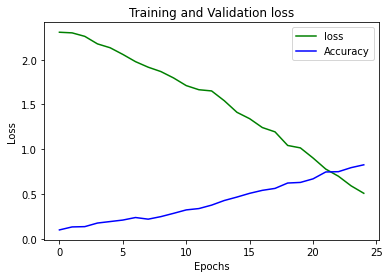

In [ ]:
plt.plot(range(25), loss_arr, 'g', label='loss')
plt.plot(range(25), acc_arr, 'b', label='Accuracy')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Summary Report:

# Copy from Submission 1 

## Import libraries

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

import keras 
from keras.datasets import mnist 
(x_train, y_train), (x_test, y_test) = mnist.load_data() 

import cv2
from scipy.signal import convolve, convolve2d
import math


### Examples of augmentation class uses

In [ ]:
def plot_images(images, titles, num_rows, width=15, height=15, padding=1.5, show_axis=False, color_map='gray'):
    fig, ax = plt.subplots(num_rows, len(images) // num_rows)
    if show_axis is False:
        [axi.set_axis_off() for axi in ax.ravel()]
    fig.set_figwidth(width)
    fig.set_figheight(height)
    fig.tight_layout(pad=padding)

    for image, title, ax in zip(images, titles, ax.flatten()):
        ax.set_title(title)
        ax.imshow(image, cmap=color_map)
        

In [ ]:
# Orgnize the data (Undo Shuffeling)
def organize_data(data, labels):
    # Initialize the list with 10 sublists (one for each digit)
    organized_data_list = [list() for _ in range(10)]
    # Iterate over every image and its label in the data
    for image, label in zip(data, labels):
        # Add the image to the appropappropriate sublist
        organized_data_list[label].append(image)
    return organized_data_list
  

### Print examples of mnist dataset

In [ ]:
images_by_digit = organize_data(x_train, y_train)
plot_images([images_by_digit[i//5][i%5] for i in range(50)], (str(i//5) for i in range(50)), 10)

### concat n images togther

In [ ]:
# Source: https://stackoverflow.com/a/30228789
import numpy as np

def concat_images(*images):
    if len(images) == 0:
        return None
        
    imgs_comb = np.hstack(images)
    return imgs_comb

### Build dataset 

In [ ]:
import random
# 000 : 4000 picutres
# 001:  4000 picures

def build_data_set():
    def create_random_triplet_images(first_digit, second_digit, third_digit):
        first_digit_images = images_by_digit[first_digit]
        second_digit_images = images_by_digit[second_digit]
        third_digit_images = images_by_digit[third_digit]
        # return [concat_images(*image) for image, _ in zip(itertools.product(images_by_digit[0], images_by_digit[1], images_by_digit[0]), range(4000))]
        return ([concat_images(random.choice(first_digit_images),
                                random.choice(second_digit_images),
                                random.choice(third_digit_images))
                                for _ in range(4000)])

    data_set = []
    for number in range(101):
        data_set.append(create_random_triplet_images(number // 100, (number // 10) % 10, number % 10))
    return data_set

%time digit_triplets = build_data_set()

### Present dataset samples

In [ ]:
random_number = random.randint(0, 100)
plot_images([digit_triplets[random_number][i] for i in range(10)], (str(random_number) for _ in range(10)), 5, padding=0.3)
len(digit_triplets[random_number]) # 4000 :)

### Building Dataset

In [ ]:
plt.imshow(digit_triplets[3][3])

In [ ]:
def split_dataset_to_X_y_arrays(data):
    all_data_tupple = [] 
    for number in range(len(data)): #101 numbers
        for img in (data[number]):
            all_data_tupple.append((img, number))

    # convert to NP.array
    all_data_tupple = np.array(all_data_tupple)
    
    # shuffle 
    random.shuffle(all_data_tupple) # Give it a g00d shuffle


    X = all_data_tupple[:, 0]
    y = all_data_tupple[:, 1]
    return X, y


def split_dataset_3way(X, y,validation_size = 0.30 ,test_size = 0.10):
    """Will Split the data to Train, Test and Validation  """
    # for example: 90% to training [= 0.1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    # from that 90%, 10% will go to [ validation = 0.1 ] 
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = validation_size)
    # will leave us with:
    # 10% - Test
    # 81% - Train
    # 9% - Validation
    return X_train, X_validation, X_test, y_train, y_validation, y_test



all_X, all_y = split_dataset_to_X_y_arrays(digit_triplets)

X_train, X_valid, X_test, y_train, y_valid, y_test = split_dataset_3way(all_X, all_y, validation_size = 0.30 ,test_size = 0.10)
print(f'\n\nX_train:{len(X_train)}, X_valid:{len(X_valid)}, X_test:{len(X_test)},\
    y_train:{len(y_train)}, y_valid:{len(y_valid)}, y_test:{len(y_test)}')

In [ ]:
plt.imshow(X_train[5])

In [ ]:
# Must inherate from dataset
class mnist_3dig_DataSet(Dataset):
    def __init__(self, x_train, y_train, transforms=None):
        super(mnist_3dig_DataSet,self).__init__()
        self.x_train = x_train
        self.y_train = y_train
        self.transforms = transforms

        
    def __getitem__(self, idx):
        x = self.x_train[idx] / self.x_train[idx].max()
        y = self.y_train[idx]
        if self.transforms:
            x = self.transforms(image=x.numpy())['image']
        
                # [Channel , H , W] -> Into The Network -> [Batch, Channel, Hight, Width]
        return x[np.newaxis, :, :], y

    def __len__(self):
        return len(self.x_train)

 

In [ ]:
# Taking only the first 600 values

mnist_3dig_train = mnist_3dig_DataSet(X_train[:600], y_train[:600], transforms=None) 
mnist_3dig_test = mnist_3dig_DataSet(X_test[:600],y_test[:600], transforms=None)
mnist_3dig_val =  mnist_3dig_DataSet(X_valid[:600], y_valid[:600], transforms=None)

### Building Pytorch's DataLodaer

In [ ]:
BS=32
mnist_3dig_loader_train = DataLoader(dataset = mnist_3dig_train, batch_size = BS, shuffle=True)
mnist_3dig_loader_test = DataLoader(dataset = mnist_3dig_test, batch_size = BS, shuffle=True)
mnist_3dig_loader_val = DataLoader(dataset = mnist_3dig_val, batch_size = BS, shuffle=True)

## Building LeNet

In [ ]:
 class LeNetModel_3dig(nn.Module):

    """input size: [1(greyScale),84(width),28(height)]"""
    def __init__(self):
        super(LeNetModel_3dig, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(1152, 120)  # fixme
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 101)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2) # 84x28 -> 42x14
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2) # 42x14 -> 21x7
        # print(f'line17: x = {x}')
        x = x.view(x.shape[0], -1)
        # print(f'line19: x = {x}')
        x = F.relu(self.fc1(x))
        # print(f'line22 well well')
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
lenet_model_3dig = LeNetModel_3dig()
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_model_3dig.parameters(), lr = 0.001, betas = (0.9, 0.999), eps = 1e-08, weight_decay=0, amsgrad=False)



In [ ]:
def train_one_epoch(dataloader , model, optimizer, epoc, criterion):
    accuracy = AverageMeter()
    losses = AverageMeter()
    model.train()
  


    for i, (image, target) in enumerate(dataloader):
        image = image.float() # float() will work better with pytorch (np.float will not run on the gpu)
        target = target.long()
        optimizer.zero_grad()
        output = model(image) # forward pass 

        loss = criterion(output, target) # Calculate loss
        loss.backward() # Calculate the derivetive 

        optimizer.step() # will modify our network according to the new values.


        pred = output.argmax(dim = 1, keepdim = True) # getting the element with the highest probability
        acc = torchmetrics.functional.accuracy(pred, target) # reading the accuracy of the network
        losses.update(loss.item(), image.size(0))
        accuracy.update(acc, image.size(0))
       
        
    return losses.avg, accuracy.avg
    

In [ ]:
from tqdm import tqdm
def train_n_epochs(num_f_epocs = 25):
    acc_dict = []
    loss_dict = []
    for i in tqdm(range(num_f_epocs)):
        losses, accuracy = train_one_epoch(mnist_3dig_loader_train, lenet_model_3dig, optimizer, i, criterion)
        loss_dict.append(losses)
        acc_dict.append(accuracy)

    print(f'\nlosses = {losses}')
    print(f'accuracy {accuracy}\n\n')
    return loss_dict, acc_dict

loss_arr, acc_arr = train_n_epochs()

In [ ]:
plt.plot(range(25), loss_arr, 'g', label='loss')
plt.plot(range(25), acc_arr, 'b', label='Accuracy')
plt.title('Loss and Accuracy loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Check Validation accuracy

In [ ]:
def inference_date(dataloader , model, optimizer, epoc, criterion):
    accuracy = AverageMeter()
    losses = AverageMeter()
    model.train()
  


    for i, (image, target) in enumerate(dataloader):
        image = image.float() # float() will work better with pytorch (np.float will not run on the gpu)
        target = target.long()
        optimizer.zero_grad()
        output = model(image) # forward pass 

        loss = criterion(output, target) # Calculate loss
        # loss.backward() # Calculate the derivetive 



        pred = output.argmax(dim = 1, keepdim = True) # getting the element with the highest probability
        acc = torchmetrics.functional.accuracy(pred, target) # reading the accuracy of the network
        losses.update(loss.item(), image.size(0))
        accuracy.update(acc, image.size(0))
       
        
    return losses.avg, accuracy.avg

losses, accuracy = inference_date(mnist_3dig_loader_val, lenet_model_3dig, optimizer, 1, criterion)
print(f'loss = {losses} , acc = {accuracy} ')



In [ ]:
def inference_single_image(single_image = mnist_3dig_val[1][0][0]):
    plt.imshow(single_image)

    image = single_image.float() # float() will work better with pytorch (np.float will not run on the gpu)
    target = target.long()
    optimizer.zero_grad()
    output = model(image) # forward pass 
    pred = output.argmax(dim = 1, keepdim = True) # getting the element with the highest probability
        
    return pred

print(inference_single_image())      
       

### Save pytorch's state

In [ ]:
def saveTorchState(epoch_num :int , model_state, optim_state, checkpoint_name = "torchCheckPoint" ):
    checkpoint = {
        "epoch":epoch_num, # An integer
        "model_state": model_state,  #model.state_dict(),
        "optim_state": optim_state #optimizer.state_dict()
    }
    
    torch.save(checkpoint, "torchCheckPoint.pth")
    

def loadTorchState(file_name = "torchCheckPoint.pth"):
    loaded_checkpoint = torch.load(file_name)
    epoch = loaded_checkpoint["epoch"]

    # we must create our model again
    model = Model(n_input_features=6)
    optimizer = optim.Adam(lenet_model_3dig.parameters(), lr = 0.001, betas = (0.9, 0.999), eps = 1e-08, weight_decay=0, amsgrad=False)

    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optim_state"])

    return epoch, model, optimizer


# ######## When using GPU (cuda) ########

# # ___ Save on GPU & Load on CPU ___
# #save
# device = torch.device("cuda")
# model.to(device)
# torch.save(model.state_dict(),PATH)

# #load
# device = torch.device("cpu")
# model = Model(*args, **kwargs)
# model.load_state_dict(torch.load(PATH, map_location=device))

# # ___ Both save & load on GPU ___
# #save
# device = torch.device("cuda")
# model.to(device)
# torch.save(model.state_dict(),PATH)

# #load
# model = Model(*args, **kwargs)
# model.load_state_dict(torch.load(PATH))
# device = torch.device("cpu")

# # ___ Save on CPU & Load on GPU ___
# #save 
# torch.save(model.state_dict(), PATH)

# #load
# device = torch.device("cuda")
# model = Model(*args, **kwargs)
# model.load_state_dict(torch.load(PATH, map_location="cuda:0"))
# model.to(device)


### Save& Load pytorch's State

# Lab8 

In [ ]:
trainset = torchvision.datasets.CIFAR10('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.CIFAR10('./data',
    download=True,
    train=False,
    transform=transform)


## tensorBoard

###Init tensor

In [ ]:
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard # Load tensor into colab
%reload_ext tensorboard # incase somthing went wrong (MAKING SURE THE PREVIUS LINE DIDNT WORK)

experiment = 0


In [ ]:
experiment += 1 
experiment += 1 
run = 0
writer = SummaryWriter(f'runs/CIFAR10_experiment_{experiment}')

In [ ]:
%tensorboard --logdir=name

In [ ]:
def get_preds_and_probs(output):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    # print('output shape', output.shape)
    # output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    # print('preds_tensor',preds_tensor)
    argmax = np.squeeze(torch.argmax(output, dim=1, keepdim=True).detach().cpu().numpy())
    # print('argmax',argmax)
    probas = F.softmax(output,dim=1).detach().cpu().numpy()
    # print('probas shape before',probas.shape)
    #probas = np.array([probas[index] for i in range(probas.shape[0]))
    # print('probas shape',probas.shape)
    # print('probas datatype', type(probas[0]))
    # print(probas[0])
    
    proba = []
    for index, sample in enumerate(probas): 
        proba.append(sample[argmax[index]])

    #print('proba shape',len(proba))
    #print(proba)
    preds = np.squeeze(preds_tensor.detach().cpu().numpy())
    # print(preds, proba)


In [ ]:
writer.add_scalar(' avrage training loss', losses.avg, epoch * len(trainloader) + i)


#### [Reference](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

In [ ]:
mport torch
import numpy as np
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

import torchvision.transforms as transforms
from torch.utils.data import Dataset , DataLoader
from sklearn.metrics import confusion_matrix
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from torch.autograd import Variable

%matplotlib inline


In [ ]:
# not that alexnet does not excpect this 
model = torchvision.models.alexnet(pretrained=True) # will download the model 

# we must work with lenet
# (lenet should be best)

# or work with other architectures 

In [ ]:
%%shell

jupyter nbconvert --to html /content/Lab8.ipynb

[NbConvertApp] Converting notebook /content/Lab8.ipynb to html
[NbConvertApp] Writing 498120 bytes to /content/Lab8.html


In [1]:
%%shell

jupyter nbconvert --to html /content/Lab8.ipynb

[NbConvertApp] WARNING | pattern u'/content/Lab8.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--no-input
    Exclude input cells and output prompts from converted document. 
    This mode is ideal for generating code-free reports.
--stdout
    Write notebook output to stdout instead of files.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default basename 'notebook.*'
--inplace
    Run

CalledProcessError: ignored